In [ ]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_metrics_over_datasets.ipynb

In [1]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

import openml

import sklearn.metrics
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.base
import sklearn.utils
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.tree

from ridgereliability import plots, metrics

import os
import multiprocessing
import logging
import time
from joblib import load, dump

In [2]:
def is_notebook():
    try:
        from IPython import get_ipython
        return get_ipython().__class__.__name__ == 'ZMQInteractiveShell'
    except ModuleNotFoundError:
        return False

In [3]:
if is_notebook():
    n_procs = multiprocessing.cpu_count()//2
    random_tasks = 1
else:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--n-processes", type=int, required=True)
    parser.add_argument("--random-tasks", type=int, default=0)
    args = parser.parse_args()
    n_procs = args.n_processes
    random_tasks = args.random_tasks

In [4]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s - %(message)s')
logging.captureWarnings(True)

In [5]:
numpy.random.seed(42)

# Compare metrics over datasets

In this notebook we collect calibration estimates for several models and datasets. The estimates are computed with the Expected Calibration Error (ECE), Balanced-ECE, and Posterior Expected Accuracy-based Calibration Error (PEACE).

Tested models:
- Random Forest
- SVM
- Logistic Regression
- Gaussian Naive Bayes
- MLP
- AdaBoost
- Decision Tree

Tested datasets (from Open ML):
- [eeg-eye-state](https://www.openml.org/d/1471), task [9983](https://www.openml.org/t/9983)
- [Phoneme](https://www.openml.org/d/1489), task [9952](https://www.openml.org/t/9952)
- [mozilla4](https://www.openml.org/d/1046), task [3899](https://www.openml.org/t/3899)
- [electricity](https://www.openml.org/d/151), task [219](https://www.openml.org/t/219)
- [Magic Telescope](https://www.openml.org/d/1120), task [3954](https://www.openml.org/t/3954)
- [artificial characters](https://www.openml.org/d/1459), task [14964](https://www.openml.org/t/14964)
- [pendigits](https://www.openml.org/d/32), task [32](https://www.openml.org/t/32)
- [letter](https://www.openml.org/d/6), task [6](https://www.openml.org/t/6)
- [JapaneseVowels](https://www.openml.org/d/375), task [3510](https://www.openml.org/t/3510)
- [glass](https://www.openml.org/d/41), task [40](https://www.openml.org/t/40)
- [micro-mass](https://www.openml.org/d/1515), task [9950](https://www.openml.org/t/9950)
- [vehicle](https://www.openml.org/d/54), task [53](https://www.openml.org/t/53)
- [synthetic-control](https://www.openml.org/d/377), task [3512](https://www.openml.org/t/3512)
- [mfeat-factors](https://www.openml.org/d/12), task [12](https://www.openml.org/t/12)
- [OVA_breast](https://www.openml.org/d/1128), task [3962](https://www.openml.org/d/1128)
- [sonar](https://www.openml.org/d/40), task [39](https://www.openml.org/t/39)
- [visualizing_livestock](https://www.openml.org/d/685), task [3577](https://www.openml.org/t/3577)
- [spectrometer](https://www.openml.org/d/313), task [145682](https://www.openml.org/t/145682)
- [disclosure_z](https://www.openml.org/d/931), task [3794](https://www.openml.org/t/3794)
- [mfeat-pixel](https://www.openml.org/d/40979), task [146824](https://www.openml.org/t/146824)

## Datasets

First of all, we need to be able to load and preprocess multiple datasets appropriately to prepare it for classification. 
To this end we implement a function that will load a dataset and classification task from OpenML.

In [18]:
def find_random_task(selected_tasks):
    tries = 0
    while True:
        df = openml.tasks.list_tasks(task_type_id=1, offset=tries*1000, output_format="dataframe", size=1000, status="active", number_missing_values=0)
        tries += 1
        if "NumberOfInstances" in df:
            df = df[(df["NumberOfInstances"] > 100) & (df["NumberOfInstances"] < 5000)]
            df = df[~df["tid"].isin(list(selected_tasks))]
            if len(df) > 0:
                task = df.sample(n=1).iloc[0]["tid"]
                selected_tasks.append(task)
                return task

In [19]:
if random_tasks > 0:
    TASKS = random_tasks
else:
    TASKS = [9983, 9952, 3899, 219, 3954, 14964, 32, 6, 3510, 40, 9950, 53, 3512, 12, 3962, 39, 3577, 145682, 3794, 146824]

In [20]:
def load_openml_task(task_id=None, selected_tasks=[]):
    
    while True:
        if task_id is None:
            curr_id = find_random_task(selected_tasks)
        else:
            curr_id = task_id

        try: 
            task = openml.tasks.get_task(curr_id)
            X, y = task.get_X_and_y("array")
            X, y = sklearn.utils.indexable(X, y)
            
            target_type = sklearn.utils.multiclass.type_of_target(y)
            if target_type not in ["binary", "multiclass"]:
                continue

            if hasattr(X, "toarray"):
                X = X.toarray()
            if hasattr(y, "toarray"):
                y = y.toarray()

            X = sklearn.preprocessing.OrdinalEncoder().fit_transform(X)

            n_repeats, n_folds, n_samples = task.get_split_dimensions()
            
            if n_folds > 10:
                continue

            folds = numpy.full((len(X)), dtype=int, fill_value=-1)
            for fold_idx in range(n_folds):
                _, test_indices = task.get_train_test_split_indices(
                    repeat=0,
                    fold=fold_idx,
                    sample=0,
                )

                folds[test_indices] = fold_idx

            splitter = sklearn.model_selection.PredefinedSplit(folds)

            return X, y, splitter, curr_id
        except:
            if task_id is not None:
                raise e

In [21]:
# noscript
X, y, splitter, task_id = load_openml_task(9952)

INFO: 2020-09-29 09:17:23,985 - pickle load data phoneme


In [22]:
# noscript
X, y, splitter, task_id = load_openml_task()

INFO: 2020-09-29 09:17:24,409 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/1000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-29 09:17:24,652 - 0.2397118s taken for [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/1000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-29 09:17:24,757 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-29 09:17:24,811 - 0.0536869s taken for [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-29 09:17:24,840 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/4245
INFO: 2020-09-29 09:17:24,900 - 0.0600820s taken for [get] request for the URL https://www.openml.org/api/v1/xml/task/4245
INFO: 2020-09-29 09:17:24,907 - Starting [get] request for the URL https://www.openml.org/api_splits/get/4245/Task_4245_splits.arff
INFO: 

## Getting calibration metrics

For each dataset we fit and evaluate multiple models. We record calibration metrics (ECE, ECE-balanced, PEACE), and some performance metrics (balanced accuracy, F1-score, accuracy). To this end we implement a function that runs this procedure for one model on one OpenML task.

In [23]:
MODELS = {
    "rf": sklearn.ensemble.RandomForestClassifier(),
    "svm": sklearn.svm.SVC(probability=True),
    "logreg": sklearn.linear_model.LogisticRegression(max_iter=1000),
    "nb": sklearn.naive_bayes.GaussianNB(),
    "mlp": sklearn.neural_network.MLPClassifier(max_iter=1000),
    "adaboost": sklearn.ensemble.AdaBoostClassifier(n_estimators=500),
    "dectree": sklearn.tree.DecisionTreeClassifier()
}

In [24]:
def get_fold_metrics_for_model(row, Xt, yt, Xv, yv):
    # get and fit fresh model
    model = sklearn.base.clone(MODELS[row["model_id"]])
    model.fit(Xt, yt)

    # compute metrics on test data
    y_probs = model.predict_proba(Xv)
    y_probs_max = y_probs.max(axis=1)
    y_preds = model.predict(Xv)
    y_test = yv

    bins = 15
    row.update({
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
        "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
        "f1": sklearn.metrics.f1_score(y_test, y_preds, average="weighted"),
        'ece': metrics.ece(y_probs_max, y_preds, y_test, bins=bins),
        'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=bins),
        'peace': metrics.peace(y_probs_max, y_preds, y_test, bins=bins),
        'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, bins=bins),
        'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace, bins=bins)
    })
    
    return row

In [25]:
def get_cv_metrics_for_model_and_task(model_id, task_id, pool, n_repeats, counter, start_at, selected_tasks):
    X, y, splitter, task_id = load_openml_task(task_id, selected_tasks=selected_tasks) # repeated runs will use cached data

    promises = []
    for i, (train_idx, test_idx) in enumerate(splitter.split()):
        for j in range(n_repeats):
            counter += 1
            if counter < start_at:
                continue

            row = {
                "fold": i,
                "repeat": j,
                "model_id": model_id,
                "task_id": task_id,
            }

            # split data
            Xt, yt = X[train_idx], y[train_idx]
            Xv, yv = X[test_idx], y[test_idx]

            promise = pool.apply_async(
                get_fold_metrics_for_model,
                (row, Xt, yt, Xv, yv)
            )
            promises.append(promise)

    logging.info(f"Promises for single cv: {len(promises)}")
    return promises, counter

## Data collection over all datasets and models

In [26]:
with multiprocessing.Pool(processes=n_procs) as pool:
    
    manager = multiprocessing.Manager()
    selected_tasks = manager.list()

    start_at = 0

    output_file = f"metrics_{int(time.time())}.dat"
    logging.info(f"Output to {output_file}")

    promises = []
    counter = 0
    
    if type(TASKS) is int:
        iter_tasks = [None]*TASKS
    else:
        iter_tasks = TASKS
    
    for model_id in MODELS.keys():
        for task_id in iter_tasks:
            tmp, counter = get_cv_metrics_for_model_and_task(model_id, task_id, pool, 1, counter, start_at, selected_tasks)
            promises.extend(tmp)
            logging.info(f"{len(promises)} promises submitted to pool ({model_id, task_id})")

    logging.info(f"{len(promises)} promises submitted to pool")

    data = []
    for promise in promises:
        try:
            data.append(promise.get())
            logging.info(f"Finished promises: {len(data)}/{len(promises)} ({len(data)/len(promises)*100:.2f}%)")
            df = pandas.DataFrame(data)
            dump(df, output_file)
        except Exception:
            logging.exception("Exception when collecting results")

INFO: 2020-09-29 09:17:26,946 - Output to metrics_1601363846.dat
INFO: 2020-09-29 09:17:26,948 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/1000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-29 09:17:27,177 - 0.2274928s taken for [get] request for the URL https://www.openml.org/api/v1/xml/task/list/type/1/limit/1000/offset/0/status/active/number_missing_values/0
INFO: 2020-09-29 09:17:27,310 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-29 09:17:27,367 - 0.0567188s taken for [get] request for the URL https://www.openml.org/api/v1/xml/estimationprocedure/list
INFO: 2020-09-29 09:17:27,395 - Starting [get] request for the URL https://www.openml.org/api/v1/xml/task/3991
INFO: 2020-09-29 09:17:27,455 - 0.0599225s taken for [get] request for the URL https://www.openml.org/api/v1/xml/task/3991
INFO: 2020-09-29 09:17:27,457 - Starting [get] request for the URL https:

In [ ]:
if not is_notebook():
    exit()

# Analysis

In [6]:
df = pandas.concat([
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601296074.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601279176.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601279139.dat")
])

In [7]:
df.head()

,fold,repeat,model_id,task_id,accuracy,balanced_accuracy,f1,ece,ece_balanced,peace,class_wise_ece,class_wise_peace
0,0,0,rf,3888,0.6875,0.609091,0.676932,0.270000,0.285625,0.238462,0.365833,0.275059
1,1,0,rf,3888,0.8125,0.754545,0.806159,0.281875,0.281875,0.223394,0.342083,0.254650
2,2,0,rf,3888,0.7500,0.654545,0.729167,0.317500,0.301875,0.288443,0.356667,0.304324
3,3,0,rf,3888,0.6250,0.563636,0.625000,0.323125,0.291875,0.289090,0.355000,0.288638
4,4,0,rf,3888,0.8125,0.754545,0.806159,0.301250,0.332500,0.287512,0.365833,0.288427


In [8]:
df.columns = ["fold", "repeat", "model_id", "task_id", "Accuracy", "Balanced Accuracy", "F1", "ECE", "Balanced ECE", "PEACE", "cw-ECE", "cw-PEACE"]

In [9]:
grouped_df = df.groupby(["model_id", "task_id", "repeat"]).aggregate("mean").drop(columns=["fold"]).reset_index()

In [10]:
grouped_df

,model_id,task_id,repeat,Accuracy,Balanced Accuracy,F1,ECE,Balanced ECE,PEACE,cw-ECE,cw-PEACE
0,adaboost,3054,0,0.575758,0.456000,0.461344,0.161482,0.084419,0.163628,0.331512,0.207475
1,adaboost,3486,0,0.177044,0.080013,0.089499,0.151466,0.063117,0.211838,0.030934,0.042257
2,adaboost,3519,0,0.737968,0.293333,0.647678,0.483397,0.055690,0.473775,0.134803,0.148915
3,adaboost,3615,0,0.898000,0.897116,0.897748,0.410615,0.402467,0.251649,0.440358,0.275037
4,adaboost,3642,0,0.808000,0.806410,0.806489,0.386946,0.396879,0.215207,0.430594,0.248124
...,...,...,...,...,...,...,...,...,...,...,...
201,svm,166919,0,0.873494,0.872521,0.874441,0.077323,0.095462,0.117298,0.115894,0.124358
202,svm,167004,0,0.670103,0.500000,0.537737,0.327339,0.476823,0.339705,0.003000,0.010558
203,svm,167005,0,0.992647,0.982143,0.992597,0.021140,0.021140,0.040002,0.024709,0.056133
204,svm,167061,0,0.867470,0.500000,0.805908,0.105566,0.307171,0.133353,0.052783,0.066677


In [11]:
def get_longform(df, cols=None, subject_cols=None):
    dfs = []
    
    if cols is None:
        cols = df.columns
    
    for col in cols:
        tmp_df = pandas.DataFrame(dict(        
            value=df[col], 
            metric=col,   
        ))
        for col2 in set(df.columns) - set(cols):
            tmp_df[col2] = df[col2]
            
        if subject_cols is not None:
            tmp_df["subject"] = df[subject_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
            
        dfs.append(tmp_df)
        
    return pandas.concat(dfs)

In [12]:
long_df = get_longform(grouped_df, grouped_df.columns[3:], ["model_id", "task_id"])

In [13]:
long_df.shape

(1648, 6)

In [14]:
long_df.head()

,value,metric,repeat,task_id,model_id,subject
0,0.575758,Accuracy,0,3054,adaboost,adaboost_3054
1,0.177044,Accuracy,0,3486,adaboost,adaboost_3486
2,0.737968,Accuracy,0,3519,adaboost,adaboost_3519
3,0.898000,Accuracy,0,3615,adaboost,adaboost_3615
4,0.808000,Accuracy,0,3642,adaboost,adaboost_3642


In [15]:
seaborn.set_theme("paper", "whitegrid", font_scale=1.5)

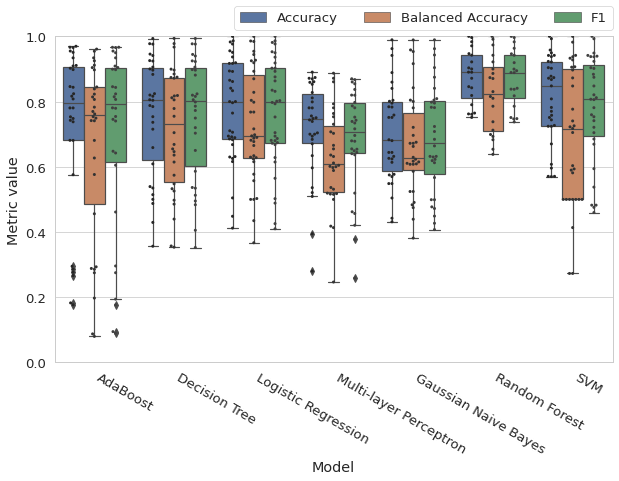

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
seaborn.boxplot(
    data=long_df[long_df["metric"].isin(["Accuracy", "Balanced Accuracy", "F1"])], 
    x="model_id", y="value", hue="metric", saturation=.7, ax=ax
)
seaborn.swarmplot(
    data=long_df[long_df["metric"].isin(["Accuracy", "Balanced Accuracy", "F1"])], 
    x="model_id", y="value", hue="metric", dodge=True, color=".25", s=3, ax=ax
)
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Model")
ax.set_ylabel("Metric value")
ax.set_ylim(0, 1)
ax.set_xticklabels(
    ["AdaBoost", "Decision Tree", "Logistic Regression", "Multi-layer Perceptron", "Gaussian Naive Bayes", "Random Forest", "SVM"],
    rotation=-30, ha="left")

plt.legend(handles[:3], labels[:3], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right',
           ncol=3, borderaxespad=0.)
plt.savefig("performance.pdf", bbox_inches="tight")

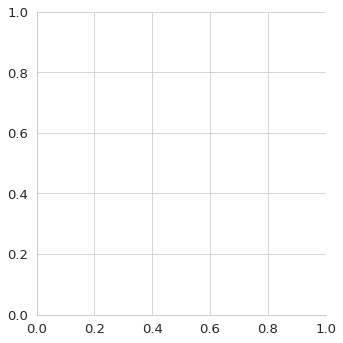

In [177]:
seaborn.displot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], x="value", hue="metric", rug=True, kind="kde")

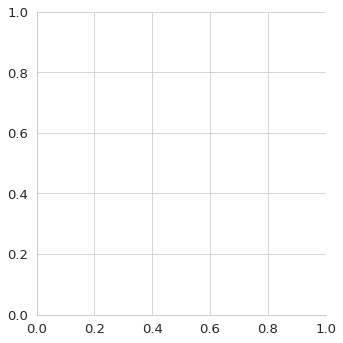

In [178]:
seaborn.displot(data=long_df[long_df["metric"].isin(["class_wise_ece", "class_wise_peace"])], x="value", hue="metric", rug=True, kind="kde")

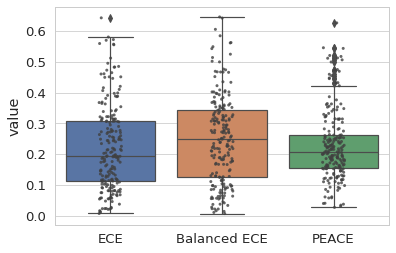

In [21]:
cols = ["ECE", "Balanced ECE", "PEACE", "cw-ECE", "cw-PEACE"]
g = seaborn.boxplot(data=long_df[long_df["metric"].isin(cols)], y="value", x="metric")
seaborn.stripplot(data=long_df[long_df["metric"].isin(["ECE", "Balanced ECE", "PEACE"])], x="metric", y="value", color=".25", s=3, alpha=.8)
g.set_xlabel("")
plt.savefig("metrics.pdf")

In [33]:
long_df["metric_ord"] = long_df["metric"].map(lambda a: numpy.unique(long_df["metric"]).tolist().index(a))

In [34]:
(grouped_df["peace"] - grouped_df["ece"]).mean()

0.006081295228402321

## Statistical testing

In [35]:
import scipy.stats
import scikit_posthocs as sp

### Pooled datasets + model

In [36]:
data = grouped_df.loc[grouped_df["repeat"] == 0, ["ece", "ece_balanced", "peace"]].values
scipy.stats.friedmanchisquare(data[0], data[1], data[2])

FriedmanchisquareResult(statistic=0.6666666666666643, pvalue=0.71653131057379)

In [37]:
long_data = get_longform(grouped_df.loc[grouped_df["repeat"] == 0, ["ece", "ece_balanced", "peace"]])
sp.posthoc_conover(long_data, val_col="value", group_col="metric", p_adjust="holm")

,ece,ece_balanced,peace
ece,-1.000000,0.051507,0.387085
ece_balanced,0.051507,-1.000000,0.256035
peace,0.387085,0.256035,-1.000000


### Per model

In [40]:
for idx, model_df in grouped_df.groupby("model_id"):
    data = model_df.loc[:, ["ece", "ece_balanced", "peace"]]
    test = scipy.stats.friedmanchisquare(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2])
    print(idx)
    print(test)
    
    if test.pvalue < 0.05:
        long_data = get_longform(data)
        print(sp.posthoc_conover(long_data, val_col="value", group_col="metric", p_adjust="holm"))
    print("-"*20)

adaboost
FriedmanchisquareResult(statistic=9.899159663865541, pvalue=0.007086385776635586)
                   ece  ece_balanced     peace
ece          -1.000000      0.445681  0.038132
ece_balanced  0.445681     -1.000000  0.157696
peace         0.038132      0.157696 -1.000000
--------------------
dectree
FriedmanchisquareResult(statistic=31.19999999999999, pvalue=1.6788275299956724e-07)
                   ece  ece_balanced     peace
ece          -1.000000      0.536432  0.242722
ece_balanced  0.536432     -1.000000  0.536432
peace         0.242722      0.536432 -1.000000
--------------------
logreg
FriedmanchisquareResult(statistic=22.49275362318841, pvalue=1.3054511023936277e-05)
                   ece  ece_balanced     peace
ece          -1.000000      0.574444  0.232014
ece_balanced  0.574444     -1.000000  0.574444
peace         0.232014      0.574444 -1.000000
--------------------
mlp
FriedmanchisquareResult(statistic=7.525423728813537, pvalue=0.02322068356751806)
              

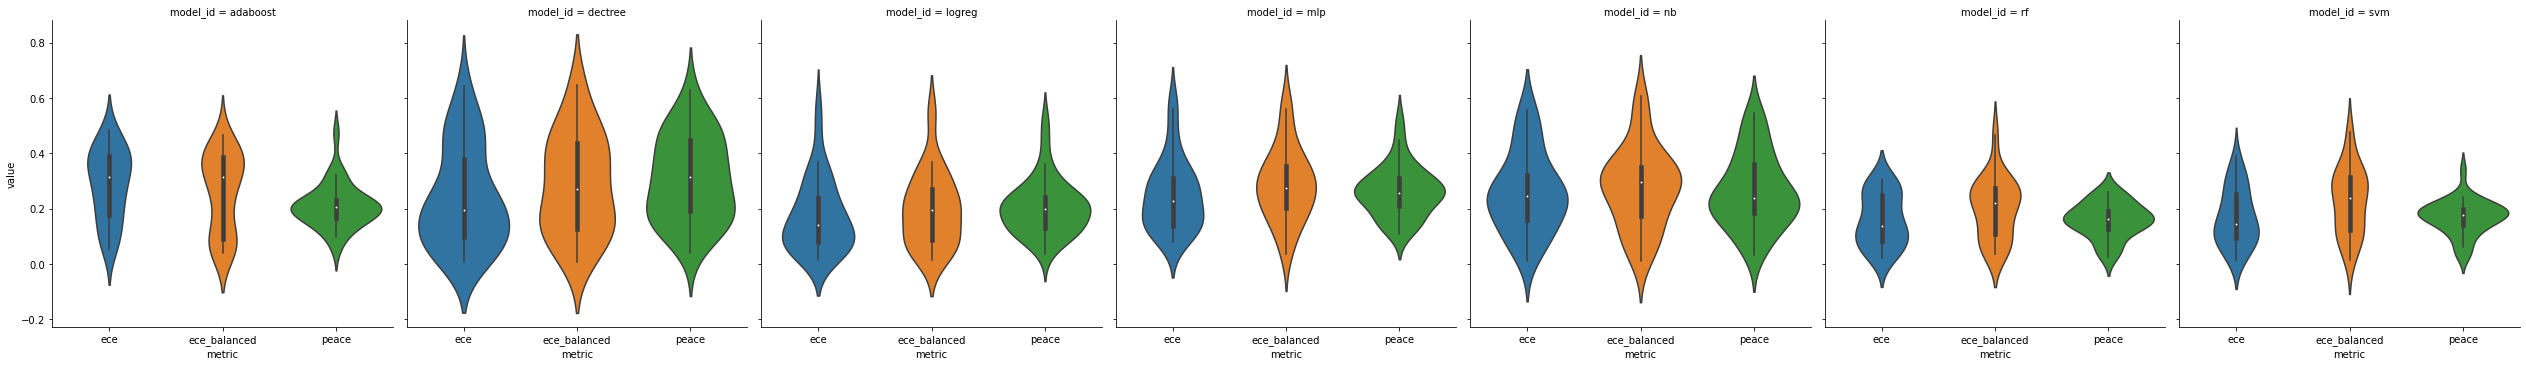

In [53]:
seaborn.catplot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], x="metric", y="value", col="model_id", kind="violin")